In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, reverse_sigmoid,
    pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, get_final_metric_df,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric, 
    plot_score_distribution, train_logistic_regression
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols, plot_heatmap
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [3]:
%load_ext autoreload
%autoreload

In [4]:
ID_COLUMNS = ["customer_ID", "target"]

### Read Data

In [201]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")
target = labels["target"]
labels.head(2)

Shape of data: (458913, 2)


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [202]:
num_statements_df = read_file(f"{RAW_DATA_PATH}/train_num_statements.csv")
num_statements_df.head(2)

Shape of data: (458913, 2)


,customer_ID,num_statements
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13


In [234]:
chris4 = read_file(f"../held_out_predictions/chris_exp4_prediction.csv").rename(columns={"prediction": "pred_c4"})
chris4["pred_c4"] = chris4["pred_c4"].apply(reverse_sigmoid)
wk19 = read_file(f"../held_out_predictions/wk_exp19_prediction.csv").rename(columns={"prediction": "pred_wk19"})
wk20 = read_file(f"../held_out_predictions/wk_exp20_prediction.csv").rename(columns={"prediction": "pred_wk20"})

Shape of data: (45900, 3)
Shape of data: (45900, 3)
Shape of data: (45900, 3)


In [235]:
id_columns = ["customer_ID", "target"]

In [236]:
result = wk19.merge(
    wk20, on=id_columns, how="left"
).merge(
    chris4, on=id_columns, how="left"
).merge(
    num_statements_df, on="customer_ID"
)

In [237]:
result.head()

,customer_ID,target,pred_wk19,pred_wk20,pred_c4,num_statements
0,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,-6.509814,-6.478890,-6.166837,13
1,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,0,-4.669691,-4.846943,-3.957760,13
2,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,1,4.685454,4.456258,5.100767,13
3,000198b3dc70edd65dbf0d7eddbcb926c6d7dbd7986af1...,0,-1.332278,-1.450405,-0.751086,13
4,0009e1a505be8b131904d3908b9d6e149108859a37cd88...,0,-5.027389,-5.008643,-4.435217,13


In [238]:
result.describe()

,target,pred_wk19,pred_wk20,pred_c4,num_statements
count,45900.000000,45900.000000,45900.000000,45900.000000,45900.000000
mean,0.259259,-2.629066,-2.623504,-1.894022,12.046100
std,0.438233,3.685739,3.636564,3.649439,2.608037
min,0.000000,-9.179749,-8.927277,-7.645880,1.000000
25%,0.000000,-5.781623,-5.739358,-5.132056,13.000000
50%,0.000000,-3.405776,-3.383570,-2.703529,13.000000
75%,1.000000,0.354697,0.329087,1.148343,13.000000
max,1.000000,8.781783,8.314610,7.424205,13.000000


In [249]:
colors = ["red", "orange", "green", "blue", "black"]

In [239]:
def get_df(result, rnn_weight=0.22, min_dart_weight=0.3):
    w1 = result["pred_wk19"]
    w2 = result["pred_wk20"]
    c4 = result["pred_c4"]
    b1_list, b2_list, b3_list = [], [], []
    temp_metric_list, final_metric_list = [], []
    for i in np.arange(min_dart_weight, 1 - min_dart_weight, 0.01):
        b1 = i
        b2 = 1 - i
        b3 = rnn_weight
        p = b1 * w1 + b2 * w2
        pred = (1 - rnn_weight) * p + rnn_weight * c4
        temp_metric, _, _ = amex_metric(result["target"], p)
        final_metric, _, _ = amex_metric(result["target"], pred)
        b1_list.append(b1)
        b2_list.append(b2)
        b3_list.append(b3)
        temp_metric_list.append(temp_metric)
        final_metric_list.append(final_metric)
    summary = pd.DataFrame(dict(b1=b1_list, b2=b2_list, b3=b3_list, metric=temp_metric_list, final_metric=final_metric_list))
    return summary

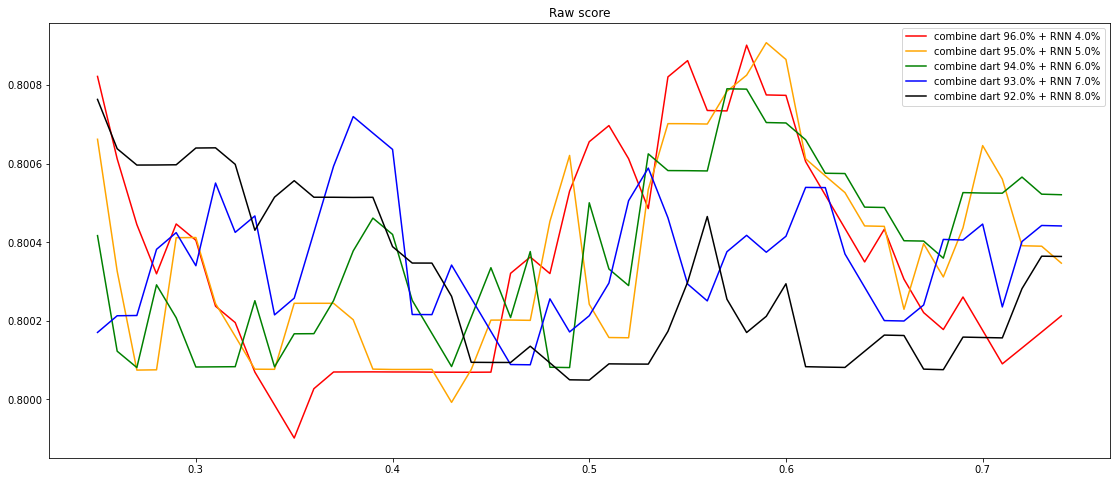

In [323]:
fig, ax = plt.subplots(figsize=(19, 8))
for idx, rnn_weight in enumerate(np.arange(0.04, 0.09, 0.01)):
    summary = get_df(result, rnn_weight, min_dart_weight=0.25)
    plt.plot(summary["b1"], summary["final_metric"], color=colors[idx],
             label=f"combine dart {1-rnn_weight:.1%} + RNN {rnn_weight:.1%}")
    # plt.plot(summary["b1"], summary["metric"], label="combine dart")
plt.legend()
plt.title("Raw score")
plt.show()

In [241]:
mscaler = MinMaxScaler()
result_minmax_scaled = result.copy()
for col in result_minmax_scaled.columns[2:5]:
    result_minmax_scaled[col] = mscaler.fit_transform(result[[col]])

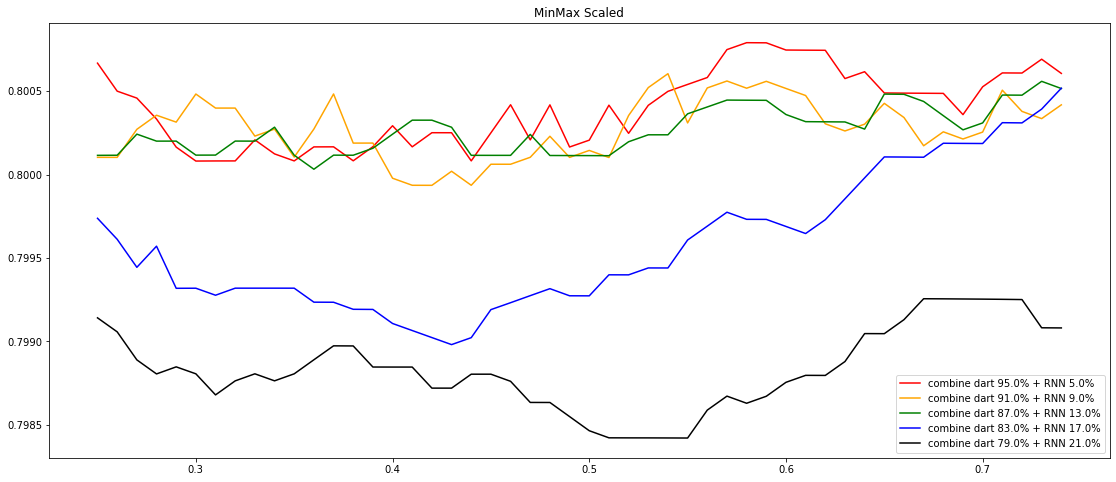

In [253]:
fig, ax = plt.subplots(figsize=(19, 8))
for idx, rnn_weight in enumerate(np.arange(0.05, 0.25, 0.04)):
    summary = get_df(result_minmax_scaled, rnn_weight, min_dart_weight=0.25)
    plt.plot(summary["b1"], summary["final_metric"], color=colors[idx],
             label=f"combine dart {1-rnn_weight:.1%} + RNN {rnn_weight:.1%}")
    # plt.plot(summary["b1"], summary["metric"], label="combine dart")
plt.legend()
plt.title("MinMax Scaled")
plt.show()

In [255]:
result_sigmoid = result.copy()
for col in result_sigmoid.columns[2:5]:
    result_sigmoid[col] = sigmoid(result[[col]])

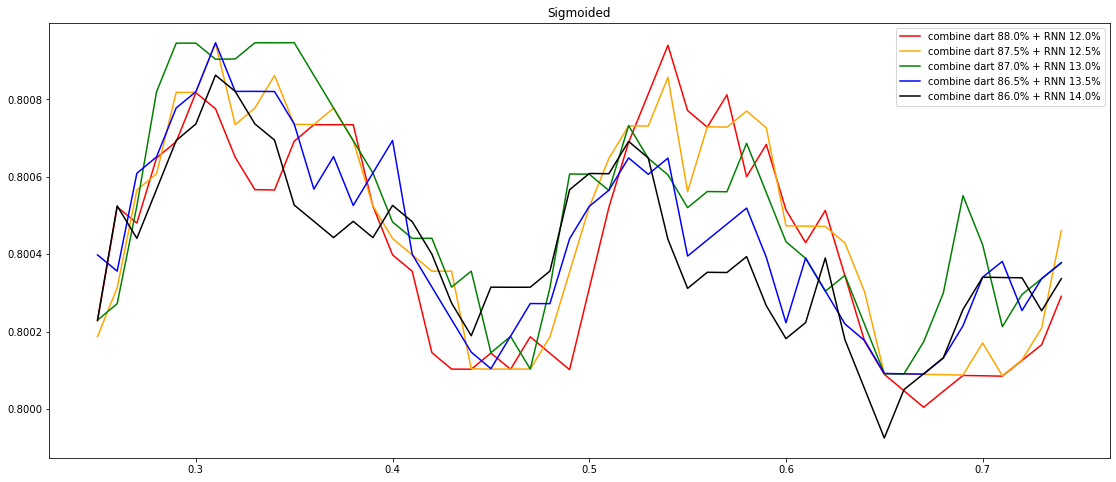

In [273]:
fig, ax = plt.subplots(figsize=(19, 8))
for idx, rnn_weight in enumerate(np.arange(0.12, 0.14, 0.005)):
    summary = get_df(result_sigmoid, rnn_weight, min_dart_weight=0.25)
    plt.plot(summary["b1"], summary["final_metric"], color=colors[idx],
             label=f"combine dart {1-rnn_weight:.1%} + RNN {rnn_weight:.1%}")
    # plt.plot(summary["b1"], summary["metric"], label="combine dart")
plt.legend()
plt.title("Sigmoided")
plt.show()

In [257]:
result_std_scaled = result.copy()
sscaler = StandardScaler()
for col in result.columns[2:5]:
    result_std_scaled[col] = sscaler.fit_transform(result[[col]])

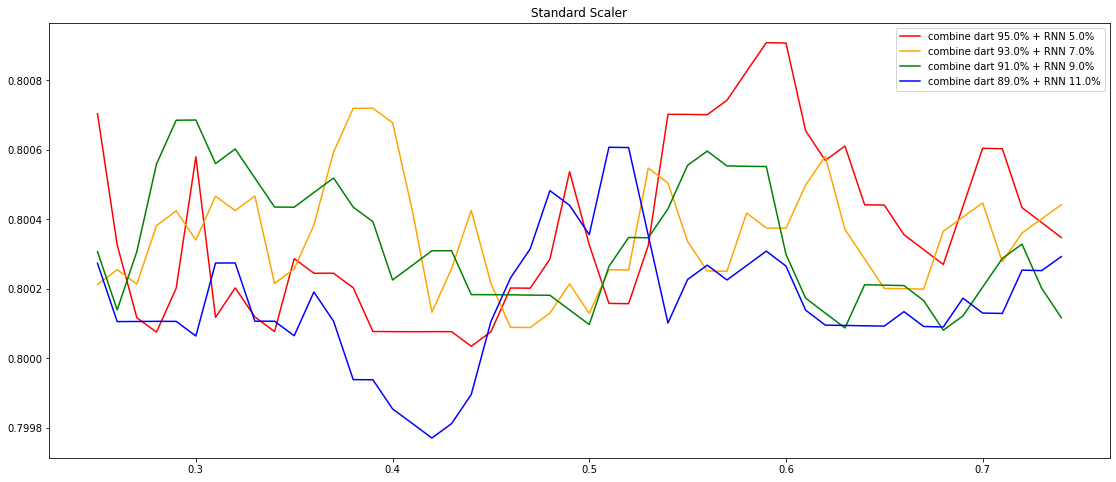

In [274]:
fig, ax = plt.subplots(figsize=(19, 8))
for idx, rnn_weight in enumerate(np.arange(0.05, 0.13, 0.02)):
    summary = get_df(result_std_scaled, rnn_weight, min_dart_weight=0.25)
    plt.plot(summary["b1"], summary["final_metric"], color=colors[idx],
             label=f"combine dart {1-rnn_weight:.1%} + RNN {rnn_weight:.1%}")
    # plt.plot(summary["b1"], summary["metric"], label="combine dart")
plt.legend()
plt.title("Standard Scaler")
plt.show()

In [260]:
result_std_scaled_sigmoid = result.copy()
sscaler = StandardScaler()
for col in result.columns[2:5]:
    result_std_scaled_sigmoid[col] = sigmoid(sscaler.fit_transform(result[[col]]))

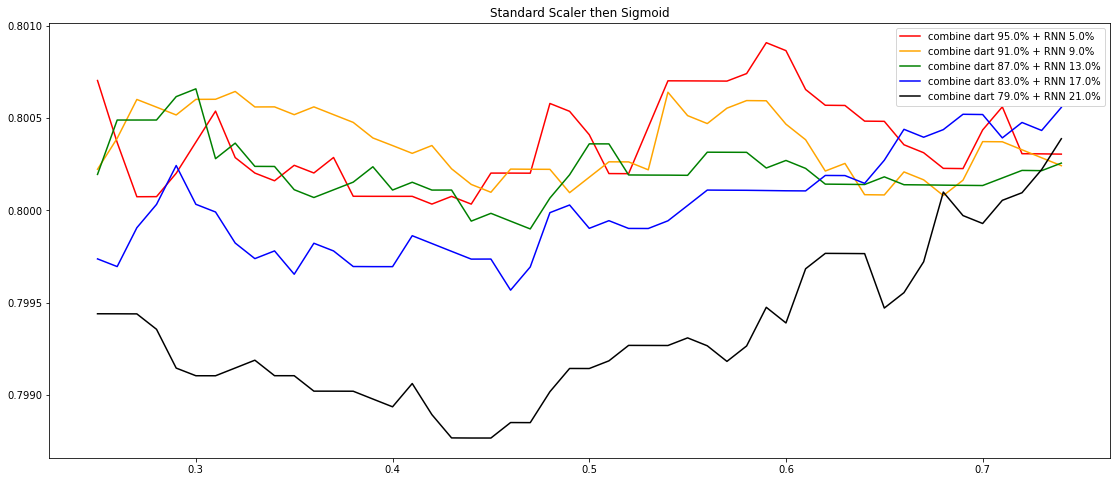

In [262]:
fig, ax = plt.subplots(figsize=(19, 8))
for idx, rnn_weight in enumerate(np.arange(0.05, 0.25, 0.04)):
    summary = get_df(result_std_scaled_sigmoid, rnn_weight, min_dart_weight=0.25)
    plt.plot(summary["b1"], summary["final_metric"], color=colors[idx],
             label=f"combine dart {1-rnn_weight:.1%} + RNN {rnn_weight:.1%}")
    # plt.plot(summary["b1"], summary["metric"], label="combine dart")
plt.legend()
plt.title("Standard Scaler then Sigmoid")
plt.show()

In [276]:
summary = get_df(result_sigmoid, rnn_weight=0.13, min_dart_weight=0.25) # result_std_scaled_sigmoid, result_std_scaled
summary.nlargest(6, "final_metric")

,b1,b2,b3,metric,final_metric
10,0.35,0.65,0.13,0.800500,0.800946
8,0.33,0.67,0.13,0.800373,0.800946
9,0.34,0.66,0.13,0.800500,0.800946
5,0.30,0.70,0.13,0.800121,0.800945
4,0.29,0.71,0.13,0.800078,0.800945
7,0.32,0.68,0.13,0.800205,0.800904


In [172]:
X = result.loc[:, get_cols(result, ["pred", "num_statements"])]
X.head()

,pred_wk19,pred_wk20,pred_c4,num_statements
0,-6.509814,-6.478890,-6.166837,13
1,-4.669691,-4.846943,-3.957760,13
2,4.685454,4.456258,5.100767,13
3,-1.332278,-1.450405,-0.751086,13
4,-5.027389,-5.008643,-4.435217,13


In [173]:
w1 = result["pred_wk19"].values
w2 = result["pred_wk20"].values
c1 = result["pred_c4"].values

In [174]:
amex_metric(result["target"], w1)

(0.8002962013831447, 0.9263907220940206, 0.6742016806722689)

In [175]:
amex_metric(result["target"], w2)

(0.8002191958095313, 0.9264888117871298, 0.6739495798319328)

In [176]:
amex_metric(result["target"], c1)

(0.7915406962317335, 0.9230813924634671, 0.66)

In [177]:
amex_metric(result["target"], 0.47 * w1 + 0.4 * w2 + 0.13 * c1)

(0.8001487956244991, 0.926684145870847, 0.6736134453781513)

### TEST Blend

### 10%

In [301]:
chris4 = read_file(f"../held_out_predictions/chris_exp4_prediction.csv").rename(columns={"prediction": "pred_c4"})
wk1 = read_file(f"../held_out_predictions/wk_exp19_prediction.csv").rename(columns={"prediction": "pred_wk19"})
wk2 = read_file(f"../held_out_predictions/wk_exp20_prediction.csv").rename(columns={"prediction": "pred_wk20"})

Shape of data: (45900, 3)
Shape of data: (45900, 3)
Shape of data: (45900, 3)


In [302]:
wk1["pred_wk19"] = wk1["pred_wk19"].apply(sigmoid)
wk2["pred_wk20"] = wk2["pred_wk20"].apply(sigmoid)

In [313]:
wk1["pred_wk19"].describe()

count    45900.000000
mean         0.275406
std          0.364799
min          0.000103
25%          0.003074
50%          0.032115
75%          0.587756
max          0.999847
Name: pred_wk19, dtype: float64

### Test

In [314]:
wk19["prediction"].describe()

count    924621.000000
mean          0.259103
std           0.355317
min           0.000045
25%           0.002886
50%           0.028063
75%           0.521143
max           0.999826
Name: prediction, dtype: float64

In [327]:
chris = read_file(f"../held_out_predictions/chris_exp4_test_prediction.csv").sort_values(by="customer_ID")

Shape of data: (924621, 2)


In [329]:
wk19 = read_file(f"{EXP_PATH}/19.lgbm_dart_923_stratified/scores_df.csv")
wk19["prediction"] = wk19.mean(axis=1).apply(sigmoid)

Shape of data: (924621, 5)


In [332]:
wk20 = read_file(f"{EXP_PATH}/20.lgbm_dart_6666_stratified/scores_df.csv")
wk20["prediction"] = wk20.mean(axis=1).apply(sigmoid)

Shape of data: (924621, 5)


In [333]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = (0.87 * (0.35 * wk19["prediction"] + 0.65 * wk20["prediction"]) + 0.13 * chris["prediction"])
sub.to_csv(f"{SUBMISSION_DATA_PATH}/another_blending_of_dart_and_rnn_attempt.csv", index=False)

In [334]:
sub

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.023285
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000884
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.030645
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.284927
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.899816
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.020646
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.879309
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.508163
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.317246


In [326]:
chris

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.055325
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.002271
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.025653
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.680218
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.947010
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.042501
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.936809
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.726925
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.521954


In [180]:
w1r = rscaler.fit_transform(w1.reshape(-1, 1))[:, 0]
w2r = rscaler.fit_transform(w2.reshape(-1, 1))[:, 0]
c1r = rscaler.fit_transform(c1.reshape(-1, 1))[:, 0]

In [181]:
w1s = sscaler.fit_transform(sigmoid(w1).reshape(-1, 1))[:, 0]
w2s = sscaler.fit_transform(sigmoid(w2).reshape(-1, 1))[:, 0]
c1s = sscaler.fit_transform(sigmoid(c1).reshape(-1, 1))[:, 0]

In [182]:
a1 = np.where(w1s > 0, w1s ** 2, -w1s ** 2)
a2 = np.where(w2s > 0, w2s ** 2, -w2s ** 2)
b1 = np.where(c1s > 0, c1s ** 2, -c1s ** 2)

In [183]:
# amex_metric(result["target"], 0.5 * a1 + 0.4 * a2 + 0.1 * b1)

In [184]:
# amex_metric(result["target"], 0.4 * (w1m + w2m) + 0.2 * c1m)

In [185]:
amex_metric(result["target"], 0.5 * w1m + 0.4 * w2m + 0.1 * c1m)

(0.8001023125557332, 0.9266752133467603, 0.6735294117647059)

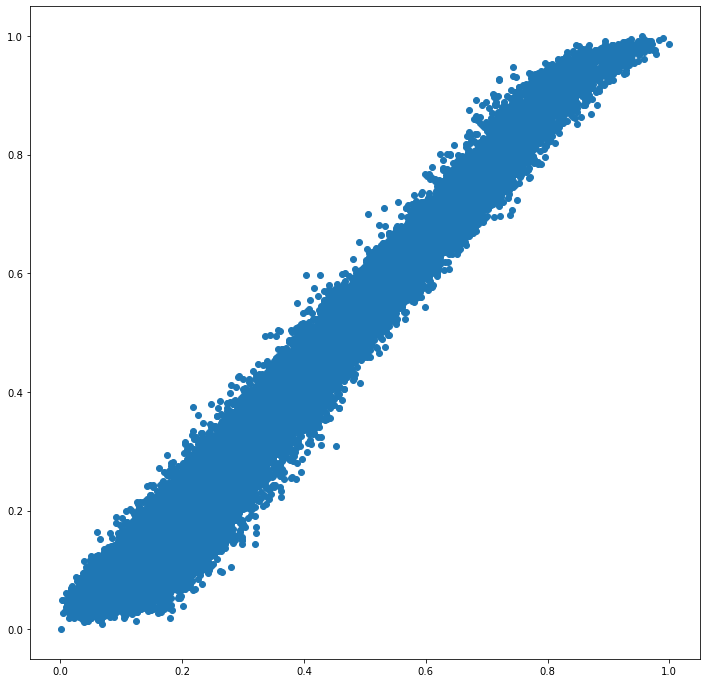

In [188]:
fig, ax = plt.subplots(figsize=(12, 12))
# plt.scatter(w, c)
plt.scatter(0.5 * (w1m + w2m), c1m)
# plt.scatter(result["pred_c4"], c + 0.26)
plt.show()

In [ ]:

robust_df = scaler.fit_transform(x)

In [638]:
amex_metric(result["target"], w2)

(0.8002191958095313, 0.9264888117871298, 0.6739495798319328)

In [680]:
result["pred_wk20"].describe()

count    45900.000000
mean        -2.623504
std          3.636564
min         -8.927277
25%         -5.739358
50%         -3.383570
75%          0.329087
max          8.314610
Name: pred_wk20, dtype: float64

In [689]:
sigmoid((w1 - np.mean(w1)) / np.std(w1))

array([0.25866471, 0.3650156 , 0.87916724, ..., 0.5881733 , 0.36014689,
       0.84225514])

In [690]:
sigmoid((w2 - np.mean(w2)) / np.std(w2))

array([0.25727426, 0.35173566, 0.87510261, ..., 0.57204684, 0.37843688,
       0.8321019 ])

In [722]:
a = sigmoid((w1 - np.min(w1)) / (np.max(w1) - np.min(w1)))

In [723]:
b = sigmoid((w2 - np.min(w2)) / (np.max(w2) - np.min(w2)))

In [724]:
c = sigmoid((c1 - np.min(c1)) / (np.max(c1) - np.min(c1)))

In [725]:
amex_metric(result["target"], 0.48 * a + 0.52 * b + 0.007 * c)

(0.800882815114347, 0.9265555461950806, 0.6752100840336135)

In [746]:
np.mean(a - b)

-0.00016016084620267337

In [807]:

    # amex_metric(result["target"], 0.45 * sigmoid(w1) + 0.45 * sigmoid(w2 + np.mean(w1 - w2)) + 0.1 * sigmoid(c1 + np.mean(w1 - c1)))

0.40, 0.37, 0.23
0.80030, 0.79887

0.41, 0.38, 0.21
0.80012, 0.79901

0.42, 0.39, 0.19
0.80040, 0.79947

0.43, 0.40, 0.17
0.80031, 0.80010

0.44, 0.41, 0.15
0.80027, 0.80023

0.45, 0.42, 0.13
0.80018, 0.80039

0.46, 0.43, 0.11
0.80013, 0.80031



In [750]:
amex_metric(result["target"], 0.45 * sigmoid(w1) + 0.45 * sigmoid(w2 + np.mean(w1 - w2)) + 0.1 * sigmoid(c1 + np.mean(w1 - c1)))

(0.8005591265456651, 0.9266644715787252, 0.674453781512605)

In [63]:
thr_max, thr_pos, thr_neutral, thr_neg, thr_min

(8.314609717296452,
 1.686714031686354,
 0.3290867968789386,
 -1.1259605984929972,
 -8.927276601637338)

In [150]:
def find_threshold(series, pct_pos=85, pct_neutral=75, pct_neg=65):
    thr_max = series.max()
    thr_pos = np.percentile(series, pct_pos)
    thr_neutral = np.percentile(series, pct_neutral)
    thr_neg = np.percentile(series, pct_neg)
    thr_min = series.min()
    return thr_max, thr_pos, thr_neutral, thr_neg, thr_min

In [151]:
def scale(x, thr_max, thr_pos, thr_neutral, thr_neg, thr_min, max_value, min_value):
    if x >= thr_pos:
        return (x - thr_pos) / (thr_max - thr_pos) + (max_value - 1)
    elif x <= thr_neg:
        return -(x - thr_neg) / (thr_min - thr_neg) + (min_value + 1)
    else:
        return (2 / (thr_pos - thr_neg)) * (x - thr_neg) + (-1)

In [259]:
def power_sign(x, upper_multiplier, lower_multiplier):
    if x >= 1:
        return (x ** upper_multiplier)
    elif x <= -1:
        return - (x ** lower_multiplier)
    else:
        return x

In [317]:
thr_max, thr_pos, thr_neutral, thr_neg, thr_min = find_threshold(
    result["pred_wk20"],
    pct_pos=99,
    pct_neutral=50,
    pct_neg=10
)
w = result["pred_wk20"].apply(lambda x: scale(x, thr_max, thr_pos, thr_neutral, thr_neg, thr_min, max_value=2, min_value=-2))
w = w.apply(lambda x: power_sign(x, 2, 2))

In [318]:
thr_max, thr_pos, thr_neutral, thr_neg, thr_min = find_threshold(
    result["pred_c4"],
    pct_pos=99,
    pct_neutral=50,
    pct_neg=10
)
c = result["pred_c4"].apply(lambda x: scale(x, thr_max, thr_pos, thr_neutral, thr_neg, thr_min, max_value=2, min_value=-2))
c = c.apply(lambda x: power_sign(x, 2, 2))

In [615]:
w2 = np.where(
    sigmoid(w) > np.percentile(sigmoid(w), 95), 
    1, 
    np.where(
        sigmoid(w) < np.percentile(sigmoid(w), 10), 
        0, 
        sigmoid(w)
    )
)

In [618]:
c2 = np.where(
    sigmoid(c) > np.percentile(sigmoid(c), 97.5), 
    1, 
    np.where(
        sigmoid(c) < np.percentile(sigmoid(c), 10), 
        0, 
        sigmoid(c)
    )
)

In [617]:
amex_metric(result["target"], 0.9 * w2 + 0.1 * c2)

(0.8003248154503206, 0.9266160174552632, 0.6740336134453782)

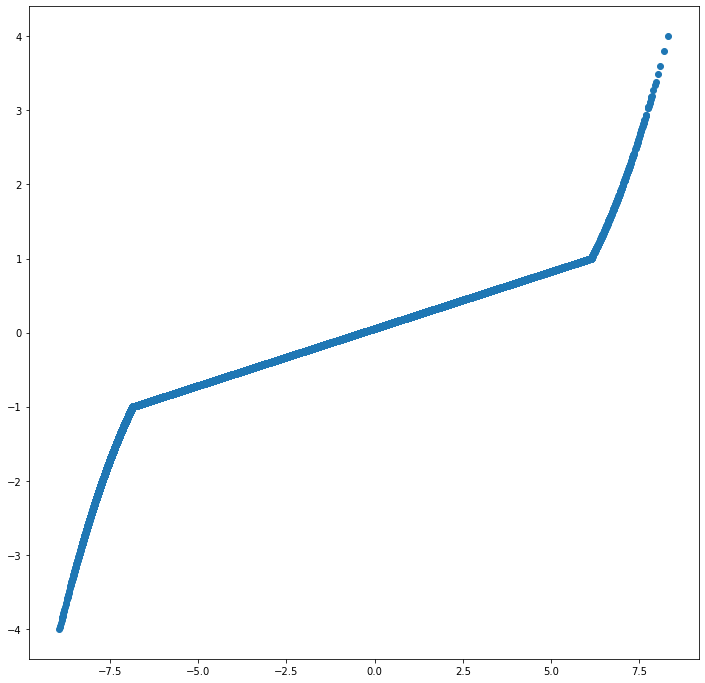

In [320]:
fig, ax = plt.subplots(figsize=(12, 12))
# plt.scatter(w, c)
plt.scatter(result["pred_wk20"], w)
# plt.scatter(result["pred_c4"], c + 0.26)
plt.show()

In [52]:
np.percentile(result["pred_wk20"], 75)

0.3290867968789386

In [53]:
np.percentile(result["pred_wk20"], 65)

-1.1259605984929972

In [50]:
m20 = np.percentile(result["pred_wk20"], 76.09)
m20

0.48101596706464733

In [48]:
result["pred_wk20"].describe()

count    45900.000000
mean        -2.623504
std          3.636564
min         -8.927277
25%         -5.739358
50%         -3.383570
75%          0.329087
max          8.314610
Name: pred_wk20, dtype: float64

In [504]:
X["pred_wk1"] = 0.5 * (X["pred_wk19"] + X["pred_wk20"])
X.drop(columns=["pred_wk19", "pred_wk20"], errors="ignore", inplace=True)

In [505]:
X["pred_wk1_sq"] = (X["pred_wk1"] ** 2) * np.where(X["pred_wk1"] > 0, 1, -1)
X["pred_c4_sq"] = (X["pred_c4"] ** 2) * np.where(X["pred_c4"] > 0, 1, -1)
X["pred_wk1_c4_cross"] = X["pred_c4"] *  X["pred_wk1"]
X["num_statements"] = np.log(X["num_statements"])

In [506]:
for col in X.columns:
    metric, _, _ = amex_metric(result["target"], X[col])
    print(col, metric)

pred_c4 0.7915406962317335
num_statements -0.03832897595106578
pred_wk1 0.8008744214088136
pred_wk1_sq 0.8008744214088136
pred_c4_sq 0.7915406962317335
pred_wk1_c4_cross -0.19302867019216624


In [507]:
X.describe()

,pred_c4,num_statements,pred_wk1,pred_wk1_sq,pred_c4_sq,pred_wk1_c4_cross
count,45900.000000,45900.000000,45900.000000,45900.000000,45900.000000,45900.000000
mean,-1.894022,2.435364,-2.626285,-15.827937,-10.506051,18.178830
std,3.649439,0.411841,3.660481,22.356274,19.724529,16.200981
min,-7.645880,0.000000,-9.046782,-81.844258,-58.459476,-2.633920
25%,-5.132056,2.564949,-5.762000,-33.200645,-26.338001,3.139129
50%,-2.703529,2.564949,-3.394835,-11.524906,-7.309069,14.163372
75%,1.148343,2.564949,0.340160,0.115709,1.318691,31.139435
max,7.424205,2.564949,8.548197,73.071663,55.118821,69.170604


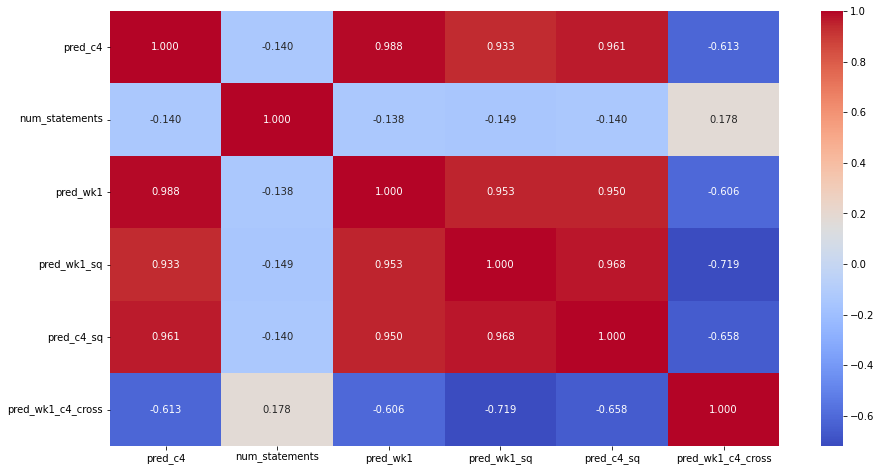

In [508]:
plot_heatmap(X.corr(), annot=True, fmt=".3f")

In [509]:
# X["pred_c4"] -= (X["pred_c4"].mean() - X["pred_wk19"].mean())

In [510]:
def scale_input(X_train, X_val, method=None):
    scaler = None
    if method is None:
        X_train_ = np.array(X_train)
        X_val_ = np.array(X_val)
    elif method == "minmax":
        scaler = MinMaxScaler()
        X_train_ = scaler.fit_transform(X_train)
        X_val_ = scaler.transform(X_val)
    elif method == "standard":
        scaler = StandardScaler()
        X_train_ = scaler.fit_transform(X_train)
        X_val_ = scaler.transform(X_val)
    elif method == "sigmoid":
        scaler = sigmoid
        X_train_ = X_train.copy()
        X_val_ = X_val.copy()
        for col in X_train.columns:
            X_train_[col] = sigmoid(X_train[col])
            X_val_[col] = sigmoid(X_val_[col])
        X_train_ = np.array(X_train_)
        X_val_ = np.array(X_val_)
    else:
        X_train_ = np.array(X_train)
        X_val_ = np.array(X_val)
        print("GG preprocessing unknown")
    return X_train_, X_val_, scaler

In [527]:
def train_logreg(X_train, y_train, method=None, random_state=33, verbose=0, return_model=False):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    metrics, train_metrics = [], []
    clf_list, scaler_list = [], []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(X_train, y_train)):
        X_tr, X_va = X_train.loc[idx_tr], X_train.loc[idx_va]
        y_tr, y_va = y_train[idx_tr], y_train[idx_va]
        X_tr, X_va, scaler = scale_input(X_tr, X_va, method=method)
        clf = LogisticRegression(
            random_state=0,
            # class_weight=class_weight,
            penalty="l2",
            # l2_ratio=0.5,
            # l1_ratio=0.31,
            solver="lbfgs",       # {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
        )
        clf.fit(X_tr, y_tr)
        clf_list.append(clf)
        scaler_list.append(scaler)
        y_train_pred = clf.predict_proba(X_tr)[:, 1]
        y_pred = clf.predict_proba(X_va)[:, 1]
        train_metric = amex_metric(y_tr.values, y_train_pred)[0]
        metric = amex_metric(y_va.values, y_pred)[0]
        metrics.append(metric)
        train_metrics.append(train_metric)
        if verbose:
            print(fold, train_metric, metric)

    df = pd.DataFrame(dict(val_amex_metric=metrics,
                           train_amex_metric=train_metrics))
    if return_model:
        return df["train_amex_metric"].mean(), df["val_amex_metric"].mean(), clf_list, scaler_list
    else:
        return df["train_amex_metric"].mean(), df["val_amex_metric"].mean()

In [531]:
train_logreg(X, result["target"], method="sigmoid")

(0.8002691581073569, 0.801385238614922)

In [532]:
train_metric, val_metric, clf_list, scaler_list = train_logreg(X, result["target"], method="sigmoid", return_model=True)

In [533]:
train_metric, val_metric

(0.8002691581073569, 0.801385238614922)

In [423]:
# for preprocesser in ["minmax", "standard", "sigmoid", "reverse_sigmoid"]:
#     metric_df, clf_list, scaler = train_logistic_regression(X, result["target"], preprocess=preprocesser)
#     val_metric = metric_df["val_amex_metric"].mean()
#     print(preprocesser, f"{val_metric:.5f}")

### Inference

In [489]:
X_test = pd.DataFrame()

In [490]:
c = read_file(f"../held_out_predictions/chris_exp4_test_prediction.csv")

Shape of data: (924621, 2)


In [491]:
X_test["pred_c4"] = c["prediction"].apply(reverse_sigmoid)

In [492]:
X_test["pred_wk19"] = read_file(f"{EXP_PATH}/19.lgbm_dart_923_stratified/scores_df.csv").mean(axis=1)
X_test["pred_wk20"] = read_file(f"{EXP_PATH}/20.lgbm_dart_6666_stratified/scores_df.csv").mean(axis=1)

Shape of data: (924621, 5)
Shape of data: (924621, 5)


In [493]:
X_test["pred_wk1"] = 0.5 * (X_test["pred_wk19"] + X_test["pred_wk20"])
X_test.drop(columns=["pred_wk19", "pred_wk20"], errors="ignore", inplace=True)

In [494]:
X_test["pred_wk1_sq"] = (X_test["pred_wk1"] ** 2) * np.where(X_test["pred_wk1"] > 0, 1, -1)
X_test["pred_c4_sq"] = (X_test["pred_c4"] ** 2) * np.where(X_test["pred_c4"] > 0, 1, -1)
X_test["pred_wk1_c4_cross"] = X_test["pred_c4"] *  X_test["pred_wk1"]

In [495]:
X.describe()

,pred_c4,pred_wk1,pred_wk1_sq,pred_c4_sq,pred_wk1_c4_cross
count,45900.000000,45900.000000,45900.000000,45900.000000,45900.000000
mean,-1.894022,-2.626285,-15.827937,-10.506051,18.178830
std,3.649439,3.660481,22.356274,19.724529,16.200981
min,-7.645880,-9.046782,-81.844258,-58.459476,-2.633920
25%,-5.132056,-5.762000,-33.200645,-26.338001,3.139129
50%,-2.703529,-3.394835,-11.524906,-7.309069,14.163372
75%,1.148343,0.340160,0.115709,1.318691,31.139435
max,7.424205,8.548197,73.071663,55.118821,69.170604


In [496]:
X_test.describe()

,pred_c4,pred_wk1,pred_wk1_sq,pred_c4_sq,pred_wk1_c4_cross
count,924621.000000,924621.000000,924621.000000,924621.000000,924621.000000
mean,-2.006146,-2.729664,-16.152842,-10.998378,18.282405
std,3.613883,3.587636,21.978309,19.690940,16.175022
min,-7.585006,-9.879664,-97.607769,-57.532309,-4.365941
25%,-5.180243,-5.778061,-33.385989,-26.834914,3.135016
50%,-2.822673,-3.502792,-12.269550,-7.967486,14.414614
75%,0.942392,0.095089,0.009042,0.888103,31.481940
max,7.412492,8.515312,72.510543,54.945045,72.068835


In [534]:
preds = []
for i in range(5):
    temp = clf_list[i].predict_proba(scaler_list[i](X))[:, 1]
    preds.append(temp)

In [539]:
amex_metric(result["target"], np.mean(preds, axis=0))

(0.8002975075654055, 0.9264773680719877, 0.6741176470588235)

In [479]:
preds = []
for i in range(5):
    temp = clf_list[i].predict_proba(scaler_list[i](X_test))[:, 1]
    preds.append(temp)

In [481]:
np.mean(preds, axis=0)

array([0.01806262, 0.01201818, 0.0166736 , ..., 0.47101285, 0.19289333,
       0.02968085])

In [482]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = np.mean(preds, axis=0)
sub.to_csv(f"{SUBMISSION_DATA_PATH}/first_real_blending_of_dart_and_rnn.csv", index=False)

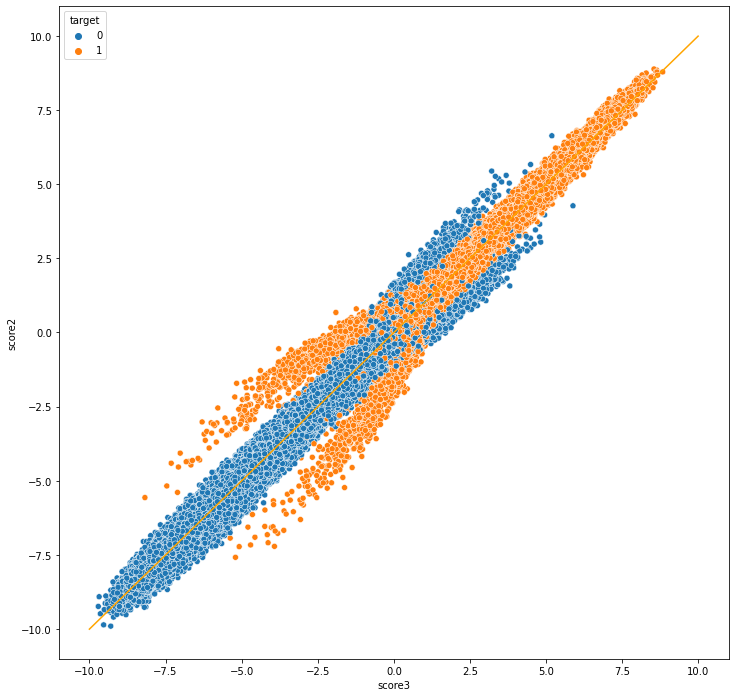

In [288]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=train_score9["score3"], y=train_score9["score2"], hue=train_score9["target"])
plt.plot(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01), color="orange", linestyle="-")
plt.show()

### END

In [434]:
# mscaler = StandardScaler()
# result = pd.DataFrame(mscaler.fit_transform(result), columns=result.columns)

In [435]:
top_thr = np.percentile(result["boost_blend"], 80)
mid_thr = np.percentile(result["boost_blend"], 70)
btm_thr = np.percentile(result["boost_blend"], 10)

In [436]:
(result["boost_blend"] >= top_thr).sum()

91783

In [437]:
result.loc[:, "final"] = np.where(
    (result["boost_blend"] >= top_thr), # & (result["reg_residual"] < 0), 
    0.9 * result["boost_blend"] + 0.1 * (result["reg_residual"] + 5),
    result["boost_blend"],
)

In [438]:
result.loc[:, "final"] = np.where(
    (result.loc[:, "final"].between(mid_thr, top_thr)) & (result["reg_residual"] > 0), 
    0.9 * result["final"] + 0.1 * (result["reg_residual"] - 0.25),
    result["final"],
)

In [439]:
result["target"] = labels['target'].values

In [440]:
amex_metric(labels["target"], result["final"])

(0.7998247588149134, 0.9266179089180755, 0.6730316087117515)

In [239]:
result = get_final_metric_df(result, pred_col="boost_blend").reset_index(drop=True)

In [240]:
result.loc[result["is_cutoff"] == 1].groupby("target")["reg_residual"].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,13598.0,4.758301,1.977495,-1.710416,3.497045,4.693073,5.934894,29.439524
1,4846.0,4.792826,1.998559,-1.271347,3.508093,4.728712,6.010576,23.135658


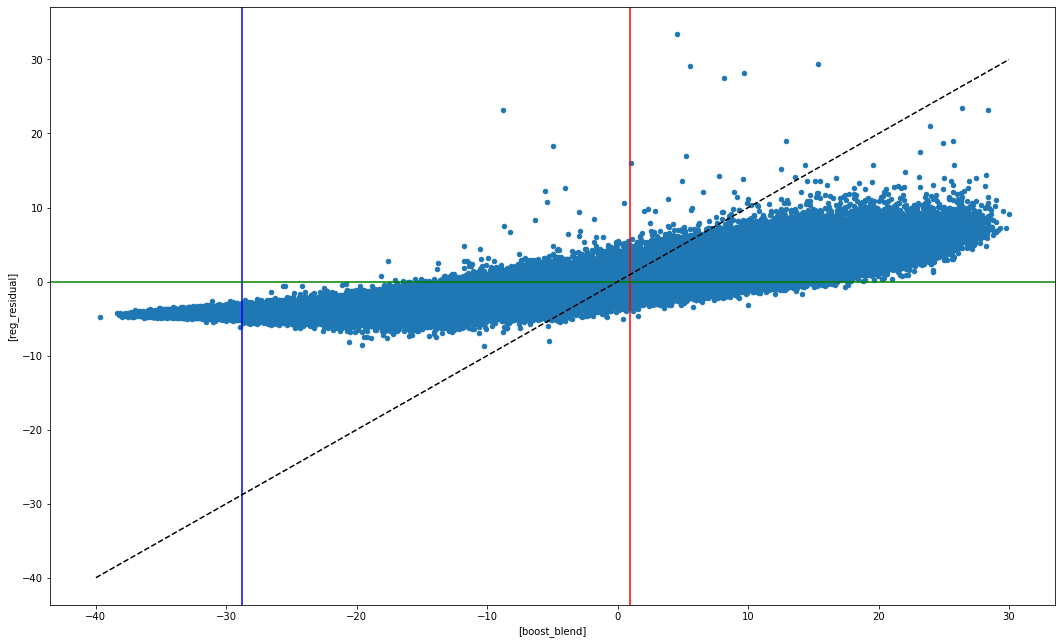

In [241]:
fig, ax = plt.subplots(figsize=(18, 11))
result.plot.scatter(x=["boost_blend"], y=["reg_residual"], ax=ax)
plt.axvline(top_thr, color="red")
plt.axvline(btm_thr, color="blue")
plt.axhline(0, color="green")
plt.plot(np.arange(-40, 30, 0.01), np.arange(-40, 30, 0.01), color="black", linestyle="--")
plt.show()

In [71]:
# result.describe()

In [521]:
X_train["sign"] = X_train.iloc[:, :6].apply(lambda x: 1 if sum([i > 0 for i in x]) > 1 else -1, axis=1)

In [522]:
X_train["sign"].value_counts(normalize=True)

-1    0.715992
 1    0.284008
Name: sign, dtype: float64

In [518]:
X_train["final"] = X_train["sign"] * X_train.iloc[:, :6].product(axis=1)

In [520]:
amex_metric(X_train["target"].values, X_train["final"].values)

(0.7995833576869003, 0.9263791568859019, 0.6727875584878985)

In [498]:
amex_metric(X_train["target"].values, X_train["final"].values)

(0.7995896537645171, 0.9263917490411357, 0.6727875584878985)

In [421]:
X_train_["max"] = X_train_.iloc[:, :5].max(axis=1)
X_train_["min"] = X_train_.iloc[:, :5].min(axis=1)
X_train_["median"] = X_train_.iloc[:, :5].median(axis=1)
X_train_["mean"] = X_train_.iloc[:, :5].mean(axis=1)
X_train_["skew"] = X_train_.iloc[:, :5].skew(axis=1)
X_train_["std"] = X_train_.iloc[:, :5].std(axis=1)

In [422]:
# X_train_["median_larger"] = (X_train_["median"] > X_train_["mean"]).astype(int)

In [423]:
X_train_["positive_skew"] = (X_train_["skew"] > 0).astype(int)

In [424]:
X_train_["high_std"] = (X_train_["std"] > 0.2).astype(int)

In [425]:
X_train_["is_full_statements"] = np.where(num_statements_df["num_statements"] == 13, 1, 0)

In [426]:
# X_train_.groupby("high_std")["target"].mean()

In [427]:
# X_train_.groupby("median_larger")["target"].mean()

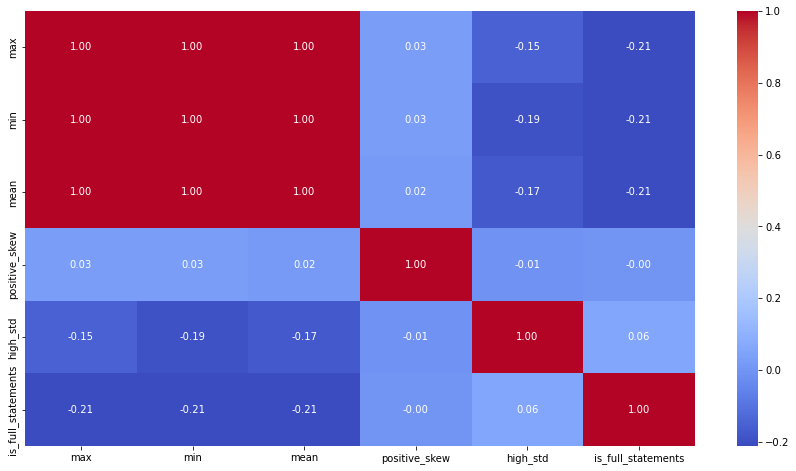

In [435]:
plot_heatmap(X_train_.corr(), annot=True, fmt=".2f")

In [131]:
default_df = result.loc[result["target"] == 1]
non_default_df = result.loc[result["target"] == 0]

In [132]:
result.loc[default_df.index, "ground_truth"] = 10 - default_df["prediction"]
result.loc[non_default_df.index, "ground_truth"] = -10 - non_default_df["prediction"]

In [191]:
# result.sort_index()["ground_truth"].to_csv(f"{RAW_DATA_PATH}/oof_residuals.csv", index=False)

In [75]:
y_train_ = train_score1["target"]

In [77]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train_, y_train_, test_size=0.2, random_state=1020, stratify=y_train_)

In [67]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = (
    (0.4 * m.fit_transform(test_score1).mean(axis=1)) + 
    (0.1 * m.fit_transform(test_score2).mean(axis=1)) + 
    (0.2 * m.fit_transform(test_score3).mean(axis=1)) + 
    (0.1 * m.fit_transform(test_score4).mean(axis=1)) +
    (0.1 * m.fit_transform(test_score5).mean(axis=1))
) / 0.9
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_10TH_blend_5_own_seeds_after_min_max_scaled.csv", index=False)